In [1]:
# !pip install livelossplot

In [2]:
import tensorflow as tf
import warnings

# Suppress specific DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print(f"Using GPU: {gpu_available}")
else:
    print("GPU not available, using CPU.")

GPU not available, using CPU.


In [3]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
import os
import joblib
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always') 

from glob import glob

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split

from tqdm import tqdm



In [5]:
# data_path = '/kaggle/input/vner-vlsp-2021/data/data/*'
class config:
    DATASET = '/kaggle/input/vner-vlsp-2021/data/*'
    DATASET_CSV = '/kaggle/input/vner-vlsp-2021/processed_data.csv'

# Load and explore VNER dataset

In [6]:
files = glob(config.DATASET)
files_csv = glob(config.DATASET_CSV)

In [7]:
#From file
# names = ['Word', 'pos', 'phrase', 'NER', 'NER1', 'NER2']
# df = pd.read_csv(files[0], sep='\t', quoting=3, names=names, skip_blank_lines=False)
# df.head(10)

#From csv
# names = ['Word', 'pos', 'phrase', 'NER', 'NER1', 'NER2']
df = pd.read_csv(files_csv[0])

In [8]:
# num_rows = int(len(df) * 0.2)  # Calculate 20% of the total rows

In [9]:
# data = df.head(num_rows)
data = df.copy()

In [10]:
data.head(10)

,Word,Tag,Sentence #
0,Mong ước,O,Sentence: 1
1,được,O,Sentence: 1
2,đến,O,Sentence: 1
3,trường,O,Sentence: 1
4,của,O,Sentence: 1
5,bé,O,Sentence: 1
6,gái,O,Sentence: 1
7,7,B-QUANTITY-AGE,Sentence: 1
8,tuổi,I-QUANTITY-AGE,Sentence: 1
9,Giờ,B-DATETIME,Sentence: 2


In [11]:
print("data shape: ", data.shape)

data shape:  (981555, 3)


In [12]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 42919
Unique tags in corpus: 90


In [13]:
words = list(set(data["Word"].values))
#denote the end of a sequence or to pad sequences to a fixed length.
words.append("ENDPAD")
#count number of unique words
num_words = len(words)
print("num_words: ", num_words)

num_words:  42920


In [14]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print("num_tag: ", num_tags)

num_tag:  90


# Retrieve Sentences and Corresponsing Tags

In [15]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [16]:
getter = SentenceGetter(data)
sentences = getter.sentences

/tmp/ipykernel_17/3131843187.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [17]:
sentences[22]

[('Nhiều', 'O'),
 ('nhân viên', 'O'),
 ('nữ', 'O'),
 ('bỏ', 'O'),
 ('việc', 'O'),
 ('tại', 'O'),
 ('Google', 'B-ORGANIZATION'),
 ('vì', 'O'),
 ('bị', 'O'),
 ('phân biệt', 'O'),
 ('đối xử', 'O')]

# Define Mappings between Sentences and Tags

In [18]:
#each unique word to a unique integer index. The index typically starts from 1 (hence the + 1)
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [19]:
for i, (word, idx) in enumerate(word2idx.items()):
    if i < 10:
        print(f"{word}: {idx}")

ESPN: 1
bình tĩnh: 2
Gói: 3
cao ngạo: 4
Lý Thánh Tông: 5
Glasgow: 6
thảnh thơi: 7
khôn lường: 8
Carles: 9
cháo song: 10


In [20]:
for i, (tag, idx) in enumerate(tag2idx.items()):
    if i < 10:
        print(f"{tag}: {idx}")

B-PERSONTYPE: 0
B-PRODUCT-COM: 1
A: 2
I-QUANTITY-CUR: 3
I-QUANTITY: 4
I-PRODUCT-COM: 5
I-PERSON: 6
B-PRODUCT-AWARD: 7
B-DATETIME-DATERANGE: 8
B-ORGANIZATION-MED: 9


# Padding Input Sentences and Creating Train/Test Splits

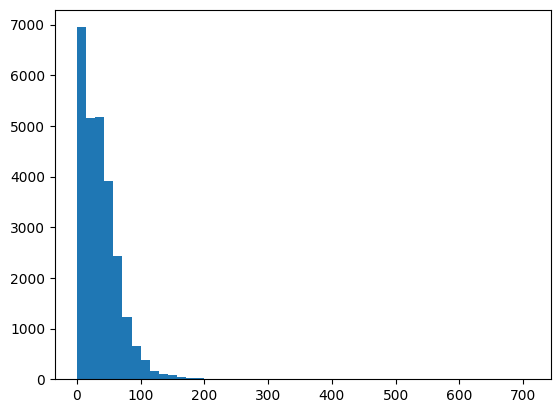

In [21]:
#X-Axis: Represents the length of the sentences (number of words).
#Y-Axis: Represents the frequency of sentences that fall into each length category (how many sentences have that particular length).
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_lengths = [len(s) for s in sentences]

# Calculate the 95th percentile
percentile_95 = np.percentile(sentence_lengths, 95)

# Print the result
print("95th percentile of sentence lengths:", percentile_95)

95th percentile of sentence lengths: 89.0


In [23]:
max_len = 90

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [24]:
X, y

(array([[30560,  9644,  6459, ..., 42919, 42919, 42919],
        [26656, 40784, 18062, ..., 42919, 42919, 42919],
        [ 7969, 13548,  7969, ..., 42919, 42919, 42919],
        ...,
        [14378, 27909, 17556, ..., 25350,  9797, 15521],
        [ 5431,  3966, 11078, ..., 42919, 42919, 42919],
        [18484, 22859,  2545, ...,  8904,  3228, 15521]], dtype=int32),
 array([[78, 78, 78, ..., 78, 78, 78],
        [78, 78, 78, ..., 78, 78, 78],
        [36, 36, 36, ..., 78, 78, 78],
        ...,
        [78, 78, 78, ..., 56, 78, 78],
        [78, 78, 78, ..., 78, 78, 78],
        [78, 78, 78, ..., 78, 78, 78]], dtype=int32))

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Build and Compile a Bidirectional LSTM Model

In [26]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [27]:
# from keras.models import Sequential

# model = Sequential()
# model.add(Input(shape=(max_len,)))
# model.add(Embedding(input_dim=num_words, output_dim=50, input_length=max_len))
# model.add(SpatialDropout1D(0.1))
# model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
# model.add(TimeDistributed(Dense(num_tags, activation="softmax")))
# model.summary()
'''
Barack Obama was born in Hawaii.
[0, 1, 2, 3, 4]
"Barack": [0.1, 0.7, 0.1, 0.1, 0.0]
"Obama": [0.1, 0.8, 0.05, 0.05, 0.0]
....
--> TimeDistributed: ensure each word in a sentence have an independent output
'''
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)

model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)

out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)

model = Model(input_word, out)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 90, 50)         │     2,146,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 90, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 90, 256)        │       183,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 90, 90)         │        23,130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,352,426 (8.97 MB)

 Trainable params: 2,352,426 (8.97 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Train the Model

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [30]:
%%time

chkpt = ModelCheckpoint("/kaggle/working/model_weights.weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # or 'val_accuracy' depending on what you want to monitor
    factor=0.5,          # factor by which the learning rate will be reduced
    patience=2,         # how many epochs with no improvement to wait before reducing the learning rate
    min_lr=1e-6,        # lower bound on the learning rate
    verbose=1           # print messages when the learning rate is reduced
)

callbacks = [chkpt, early_stopping, reduce_lr]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=9,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/9
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8468 - loss: 0.6431
Epoch 1: val_loss improved from inf to 0.28043, saving model to /kaggle/working/model_weights.weights.h5
528/528 ━━━━━━━━━━━━━━━━━━━━ 107s 185ms/step - accuracy: 0.8468 - loss: 0.6426 - val_accuracy: 0.9408 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 2/9
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8643 - loss: 0.2541
Epoch 2: val_loss improved from 0.28043 to 0.24833, saving model to /kaggle/working/model_weights.weights.h5
528/528 ━━━━━━━━━━━━━━━━━━━━ 96s 182ms/step - accuracy: 0.8643 - loss: 0.2541 - val_accuracy: 0.9453 - val_loss: 0.2483 - learning_rate: 0.0010
Epoch 3/9
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8691 - loss: 0.2233
Epoch 3: val_loss improved from 0.24833 to 0.21328, saving model to /kaggle/working/model_weights.weights.h5
528/528 ━━━━━━━━━━━━━━━━━━━━ 98s 186ms/step - accuracy: 0.8691 - loss: 0.2233 - val_accuracy: 0.9509 - val_loss: 0.2133 - learn

# Plot train and val

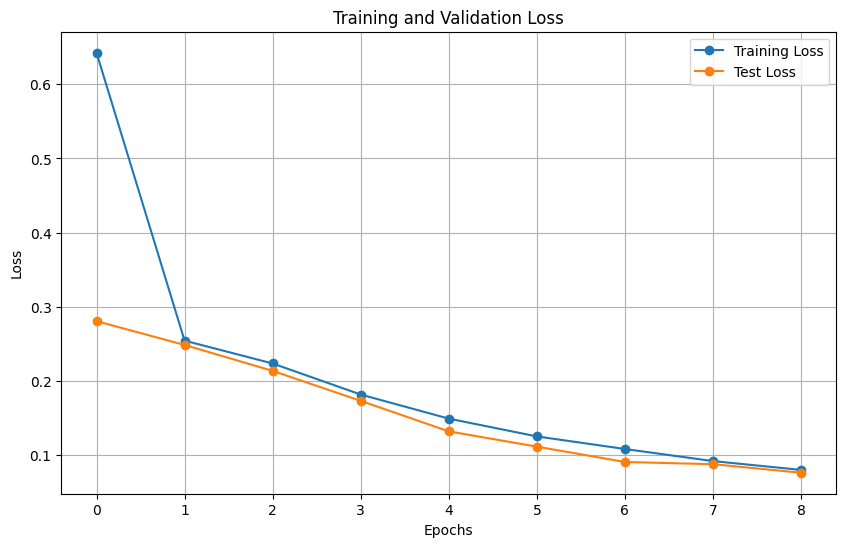

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [32]:
model.save('/kaggle/working/model_lstm.h5')

# Evaluate Named Entity Recognition Model

In [33]:
model.evaluate(x_test, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9678 - loss: 0.1285


[0.12981627881526947, 0.9677461385726929]

In [34]:

# Step 3: Flatten the predictions and the true labels


# Step 1: Predict the classes for the test set
y_pred = model.predict(x_test)

# Step 2: Convert predictions to class labels (argmax across the last dimension)
y_pred_classes = np.argmax(y_pred, axis=-1)

y_pred_flat = y_pred_classes.flatten()
y_test_flat = y_test.flatten()

unique_pred_classes = np.unique(y_pred_flat)
unique_true_classes = np.unique(y_test_flat)

print("Unique predicted classes:", unique_pred_classes)
print("Unique true classes:", unique_true_classes)

165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step
Unique predicted classes: [ 0  1  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 47 48 49 50 52 53 54
 56 57 58 61 62 63 64 66 68 69 70 71 72 73 74 75 76 77 78 79 82 83 84 86
 87 88 89]
Unique true classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


In [35]:
from sklearn.metrics import classification_report

# Get the unique labels for the classification report
labels = np.unique(np.concatenate((unique_pred_classes, unique_true_classes)))

print(classification_report(y_test_flat, y_pred_flat, target_names=[tag for i, tag in enumerate(tag2idx.keys()) if i in labels]))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

          B-PERSONTYPE       0.76      0.52      0.61       985
         B-PRODUCT-COM       0.57      0.41      0.48       246
                     A       0.00      0.00      0.00         1
        I-QUANTITY-CUR       0.72      0.88      0.80       643
            I-QUANTITY       0.54      0.28      0.37      1006
         I-PRODUCT-COM       0.51      0.47      0.49       203
              I-PERSON       0.88      0.66      0.75       837
       B-PRODUCT-AWARD       1.00      0.13      0.24        15
  B-DATETIME-DATERANGE       0.42      0.06      0.10        86
    B-ORGANIZATION-MED       0.51      0.46      0.49        56
       B-MISCELLANEOUS       0.34      0.23      0.27       138
    B-LOCATION-GPE-GEO       0.00      0.00      0.00         1
        B-QUANTITY-CUR       0.56      0.61      0.59       257
         B-PHONENUMBER       0.54      0.26      0.35        27
       B-EVENT-NATURAL       1.00      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# i = np.random.randint(0, x_test.shape[0]) #659
# p = model.predict(np.array([x_test[i]]))
# p = np.argmax(p, axis=-1)
# y_true = y_test[i]
# print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
# print("-" *30)
# for w, true, pred in zip(x_test[i], y_true, p[0]):
#     print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

In [37]:
import numpy as np

# Tìm các chỉ số không có nhãn O
indices_not_O = [i for i in range(y_test.shape[0]) if not np.all(y_test[i] == tag2idx["O"])]

# Chọn tối đa 20 mẫu để test
sample_indices = np.random.choice(indices_not_O, size=min(20, len(indices_not_O)), replace=False)

for i in sample_indices:
    p = model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" * 30)
    
    for w, true, pred in zip(x_test[i], y_true, p[0]):
        # Kiểm tra nếu true không phải là "O" trước khi in
        if tags[true] != "O":
            print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Word           True 	 Pred

------------------------------
IoT            B-PRODUCT-COM	B-PRODUCT-COM
IoT            B-PRODUCT-COM	B-PRODUCT-COM
cảm            B-PRODUCT-COM	B-PRODUCT-COM
biến           I-PRODUCT-COM	O
vi             B-PRODUCT-COM	B-PRODUCT-COM
điều khiển     I-PRODUCT-COM	O
thiết bị       B-PRODUCT-COM	O
phát           I-PRODUCT-COM	O
thu            B-PRODUCT-COM	O
năng lượng     I-PRODUCT-COM	O
đèn            B-PRODUCT-COM	B-PRODUCT
LED            I-PRODUCT-COM	I-PRODUCT
máy bay        B-PRODUCT-COM	I-PRODUCT
không          I-PRODUCT-COM	O
người          I-PRODUCT-COM	O
lái            I-PRODUCT-COM	O
drone          B-PRODUCT-COM	O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Word           True 	 Pred

------------------------------
22/9           B-DATETIME-TIME	I-DATETIME-DATE
Công an        B-ORGANIZATION	B-ORGANIZATION
quận           B-LOCATION	I-ORGANIZATION
3              I-LOCATION	I-LOCATION
TP.HCM         B-LOCATION	B-LOCATION-